In [1]:
%run setup.py

In [2]:
t, y = np.loadtxt('../lc/10080943_lc.txt', usecols=(0,1)).T

from scipy.ndimage import gaussian_filter
from maelstrom.utils import amplitude_spectrum
y_low = gaussian_filter(y,1.8)
y_high = y - y_low

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f31f8640fd0>,
      dtype=object)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


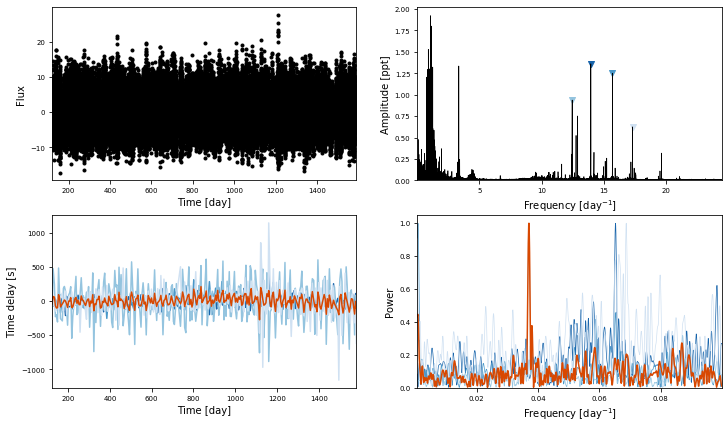

In [3]:
ms = Maelstrom(t, y, freq=np.array([13.94758557, 15.68333011, 
                                    12.45257641,  
                                    17.30504092,
                                   ]))
ms.first_look(segment_size=5)

In [9]:
ms.setup_orbit_model(period=15.335878873082686)
opt = ms.optimize()

In [10]:
freq = ms.freq
time, flux = ms.time, ms.flux

In [11]:
pinned_lt = [
    44.,
    -43.
]
nu_arr_positive = np.array([
    13.94758524
])
nu_arr_negative = np.array([
    15.68332996, 12.45257786
])

In [12]:
period_guess, a_guess = 15.335878873082686, 43.18400031048695

In [13]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(opt['period']), sd=10,
                                      testval=np.log(opt['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    a1sini = pm.Normal('a1sini', mu=pinned_lt[0], sd=10, testval=pinned_lt[0])
    a2sini = pm.Normal('a2sini', mu=pinned_lt[1], sd=10, testval=pinned_lt[1])
    nu1 = pm.Normal('nu1', mu=nu_arr_positive, sd=0.001, testval=nu_arr_positive, shape=len(nu_arr_positive))
    nu2 = pm.Normal('nu2', mu=nu_arr_negative, sd=0.001, testval=nu_arr_negative, shape=len(nu_arr_negative))
    
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=opt['varpi'])
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=opt['eccen'])
    
    orbit1 = Orbit(period=period, 
                  lighttime=a1sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu1)
    
    orbit2 = Orbit(period=period, 
                  lighttime=a2sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu2)
    
    full_lc = orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean
    
#     # GP parameters
    logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/0.5))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))

In [14]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[W_hat_cos_neg, W_hat_cos_pos, W_hat_sin_neg, W_hat_sin_pos])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu1, nu2])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
    map_params = xo.optimize(start=map_params, vars=[omega, eccen])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)

[phi_angle__, logs_lc, a1sini, a2sini, nu1, nu2, mean, omega_angle__, eccen_interval__, logw0_interval__, logpower]


optimizing logp for variables: [mean]
5it [00:00,  9.52it/s, logp=-3.836893e+05]
message: Optimization terminated successfully.
logp: -383689.3692174602 -> -383689.3473209515
optimizing logp for variables: [logs_lc]
10it [00:00, 17.42it/s, logp=-1.902093e+05]
message: Optimization terminated successfully.
logp: -383689.3473209515 -> -190209.27938830102
optimizing logp for variables: [phi]
15it [00:00, 15.69it/s, logp=-1.901887e+05]
message: Optimization terminated successfully.
logp: -190209.27938830102 -> -190188.65225111056
optimizing logp for variables: [nu2, nu1]
63it [00:04, 14.42it/s, logp=-1.901886e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -190188.65225111056 -> -190188.64248278816
optimizing logp for variables: [logpower, logw0, eccen, omega, mean, nu2, nu1, a2sini, a1sini, logs_lc, phi]
189it [00:15, 12.36it/s, logp=-1.302254e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -190188.64248278816 -> -130225.

In [15]:
map_params

{'logP_interval__': array(-0.05248379),
 'phi_angle__': array([-2.6717797 ,  3.58629416]),
 'logs_lc': array(0.26119389),
 'a1sini': array(50.79542626),
 'a2sini': array(-43.25748767),
 'nu1': array([13.9475852]),
 'nu2': array([15.68332996, 12.45257796]),
 'mean': array(-0.00610707),
 'omega_angle__': array([-0.53364851,  4.44015235]),
 'eccen_interval__': array(-0.14562012),
 'logw0_interval__': array(2.31626268),
 'logpower': array(9.4627941),
 'logP': array(2.7305253),
 'period': array(15.34094343),
 'phi': array(-0.64029173),
 'omega': array(-0.11961325),
 'eccen': array(0.46319551),
 'logw0': array(2.05531472),
 'logS0': array(1.24153522)}

In [ ]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, 
        draws=1000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'traces/NEW/10080943_PM')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, eccen, omega, mean, nu2, nu1, a2sini, a1sini, logs_lc, phi, logP]
Sampling 4 chains:   1%|          | 46/8000 [08:17<32:22:46, 14.66s/draws]